In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "macosko_2015.h5ad"))
adata

AnnData object with n_obs × n_vars = 44808 × 24658
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,cluster_ids,labels
r1_GGCCGCAGTCCG,2,Retinal ganglion cells
r1_CTTGTGCGGGAA,2,Retinal ganglion cells
r1_GCGCAACTGCTC,2,Retinal ganglion cells
r1_GATTGGGAGGCA,2,Retinal ganglion cells
r1_GTGCCGCCTCTC,25,Cones


In [4]:
adata.obs["labels"].value_counts()

Rods                      29400
Bipolar cells              6285
Amacrine cells             4426
Cones                      1868
Muller glia                1624
Retinal ganglion cells      432
Vascular endothelium        252
Horizontal cells            252
Fibroblasts                  85
Microglia                    67
Pericytes                    63
Astrocytes                   54
Name: labels, dtype: int64

In [5]:
colors = {
    "Amacrine cells": "#A5C93D",
    "Astrocytes": "#8B006B",
    "Bipolar cells": "#2000D7",
    "Cones": "#538CBA",
    "Fibroblasts": "#8B006B",
    "Horizontal cells": "#B33B19",
    "Microglia": "#8B006B",
    "Muller glia": "#8B006B",
    "Pericytes": "#8B006B",
    "Retinal ganglion cells": "#C38A1F",
    "Rods": "#538CBA",
    "Vascular endothelium": "#8B006B",
}

## Preprocessing

In [6]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 44808 × 17924
    obs: 'cluster_ids', 'labels'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.19
CPU times: user 1.37 s, sys: 1.43 s, total: 2.8 s
Wall time: 2.7 s


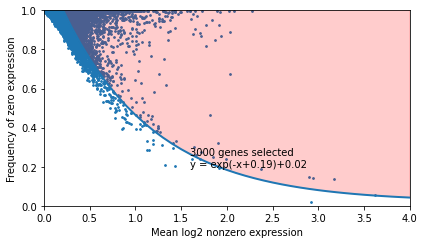

In [7]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [9]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## Utils

In [10]:
def rotate(deg):
    rad = deg * np.pi / 180
    return np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)],
    ])

## Standard t-SNE

In [11]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    learning_rate=200,
    n_iter=750,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

--------------------------------------------------------------------------------
TSNE(initialization='random', learning_rate=200, metric='cosine', n_iter=750,
     n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 10.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.12 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 6.8607, 50 iterations in 1.9088 sec
Iteration  100, KL divergence 6.8607, 50 iterations in 1.9391 sec
Iteration  150, KL divergence 6.5340, 50 iterations in 1.8986 sec
Iteration  200, KL divergence 5.6864, 50 iterations in 1.9277 sec
Iteration  250, KL divergence 5.4559, 50 iterations in 1.8473 sec
   --> Time elapsed: 9.52 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 itera

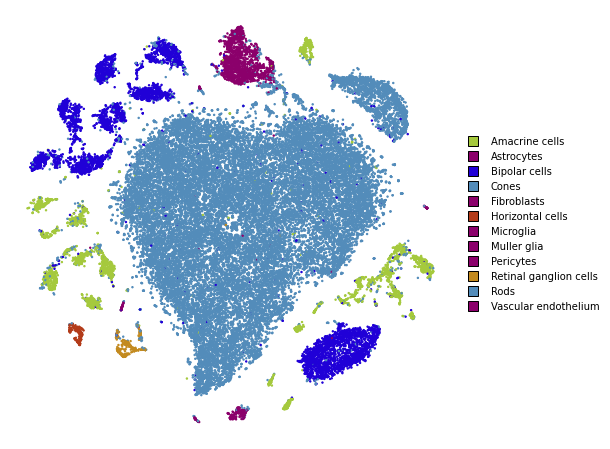

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_standard @ rotate(-130), adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax)

## Modern embedding

In [14]:
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding_modern = openTSNE.TSNE(
    initialization="pca",
    learning_rate="auto",
    n_iter=500,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"], affinities=affinities)

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 43.82 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 44.77 seconds
--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.18 seconds
===> Running optimization with exaggeration=12.00, lr=3734.00 for 250 iterations...
Iteration   50, KL divergence 4.4122, 50 iterations in 15.0498 sec
Iteration  100, KL divergence 3.9951, 50 iterations in 14.5889 sec
Iteration  150, KL divergence 3.9394, 50 iterations in 15.4732 sec
Iteration  200, KL divergence 3.9167, 50 iterations in 14.9313 sec
Iteration  250, KL divergence 3.9047, 50 iterations in 15.0864 sec
   --> Time elapsed: 75.13 seconds
===> Running optimization with exaggeration=1.00, lr=3734.00 f

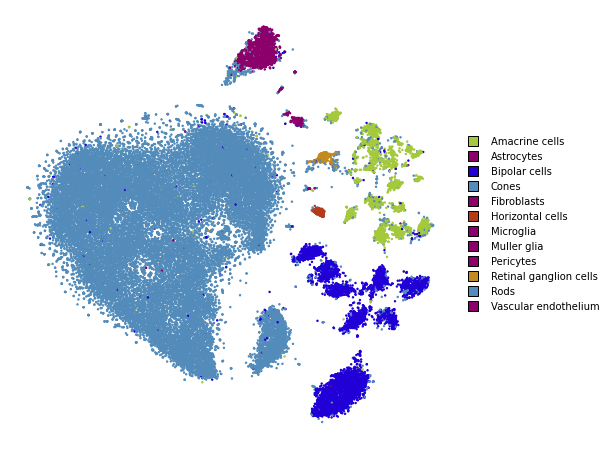

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_modern, adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax)

## Transform

### Prepare new data

In [16]:
new = anndata.read_h5ad(path.join("..", "data", "h5ad", "shekhar_2016.h5ad"))
new

AnnData object with n_obs × n_vars = 26830 × 24904
    obs: 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [17]:
new.obs["labels"].value_counts()

rod bipolar cell              10888
type 5 cone bipolar cell       4641
Mueller cell                   2945
type 1 cone bipolar cell       1883
type 7 cone bipolar cell       1759
type 6 cone bipolar cell       1702
type 3 cone bipolar cell       1352
type 2 cone bipolar cell        558
type 4 cone bipolar cell        398
type 8/9 cone bipolar cell      313
amacrine cell                   252
retinal rod cell                 91
retinal cone cell                48
Name: labels, dtype: int64

In [18]:
new.obs["labels"] = new.obs["labels"].astype(str)
new.obs["labels"][new.obs["labels"].str.contains("bipolar cell")] = "retinal bipolar neuron"
new.obs["labels"] = new.obs["labels"].replace({
    "retinal rod cell": "Rods",
    "retinal bipolar neuron": "Bipolar cells",
    "amacrine cell": "Amacrine cells",
    "retinal cone cell": "Cones",
    "Mueller cell": "Muller glia",
    "retinal ganglion cell": "Retinal ganglion cells",
    "endothelial cell": "Vascular endothelium",
    "retina horizontal cell": "Horizontal cells",
    "fibroblast": "Fibroblasts",
    "microglial cell": "Microglia",
    "pericyte cell": "Pericytes",
    "astrocyte": "Astrocytes",
})
new.obs["labels"].value_counts()

Bipolar cells     23494
Muller glia        2945
Amacrine cells      252
Rods                 91
Cones                48
Name: labels, dtype: int64

### Align data sets

In [19]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "macosko_2015.h5ad"))
adata

AnnData object with n_obs × n_vars = 44808 × 24658
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [20]:
adata.var_names = adata.var_names.str.upper()
new.var_names = new.var_names.str.upper()

In [21]:
new = new[:, ~new.var_names.duplicated()]

In [22]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['KITL', 'TMTC3', 'CEP290', '4930430F08RIK', '1700017N19RIK', 'MGAT4C',
       'RASSF9', 'LRRIQ1', 'ADGB', 'SLC6A15',
       ...
       'TMED6', '1700018B08RIK', 'RPRL3', 'GM23986', 'GM15656', 'TREH',
       'BC050972', 'GM23791', 'GM15023', 'VSIG1'],
      dtype='object', length=20808)

In [23]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [24]:
adata.shape, new.shape

((44808, 20808), (26830, 20808))

In [25]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

In [26]:
adata

AnnData object with n_obs × n_vars = 44808 × 20808
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.36
CPU times: user 1.44 s, sys: 1.38 s, total: 2.82 s
Wall time: 2.79 s


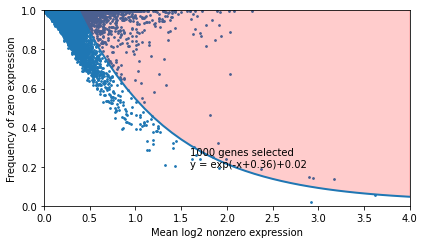

In [27]:
%time gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [28]:
adata_1000 = adata[:, gene_mask]
new_1000 = new[:, gene_mask]

### Find embeddings for new data

In [29]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    adata_1000.X.toarray(),
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 23.81 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.15 seconds
CPU times: user 2min 6s, sys: 3.48 s, total: 2min 10s
Wall time: 25.1 s


In [30]:
embedding = openTSNE.TSNEEmbedding(
    embedding_modern.view(np.ndarray),
    affinities,
    n_jobs=8,
    verbose=True,
)

In [63]:
%%time
new_embedding = embedding.transform(
    new_1000.X.toarray(),
    learning_rate=0.01,
    n_iter=500,
    exaggeration=100,
)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 16.53 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.13 seconds
===> Running optimization with exaggeration=4.00, lr=0.01 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=100.00, lr=0.01 for 500 iterations...
Iteration   50, KL divergence 535595.8799, 50 iterations in 0.6427 sec
Iteration  100, KL divergence 534625.6710, 50 iterations in 0.6465 sec
Iteration  150, KL divergence 533768.7641, 50 iterations in 0.6542 sec
Iteration  200, KL divergence 533009.3275, 50 iterations in 0.6543 sec
Iteration  250, KL divergence 532332.3022, 50 iterations in 0.6580 sec
Iteration  300, KL divergence 531723.9995, 50 iterations in 0.6667 sec
Iteration  350, KL divergence 531174.1643, 50 iterations in 0.6621 sec
Iteration  400, KL divergence 530674.4305, 50 iterations in 0.6638 sec
Iteration  450, KL divergence 530217.4183, 

In [64]:
new_embedding.optimize(500, exaggeration=1, learning_rate=1, inplace=True)

===> Running optimization with exaggeration=1.00, lr=1.00 for 500 iterations...
Iteration   50, KL divergence 401820.6695, 50 iterations in 0.6082 sec
Iteration  100, KL divergence 401082.1277, 50 iterations in 0.6031 sec
Iteration  150, KL divergence 400784.5622, 50 iterations in 0.5925 sec
Iteration  200, KL divergence 400607.3576, 50 iterations in 0.5830 sec
Iteration  250, KL divergence 400497.0214, 50 iterations in 0.5964 sec
Iteration  300, KL divergence 400430.5550, 50 iterations in 0.5813 sec
Iteration  350, KL divergence 400373.8563, 50 iterations in 0.5794 sec
Iteration  400, KL divergence 400326.5996, 50 iterations in 0.5935 sec
Iteration  450, KL divergence 400283.5203, 50 iterations in 0.5793 sec
Iteration  500, KL divergence 400243.4290, 50 iterations in 0.5765 sec
   --> Time elapsed: 5.89 seconds


PartialTSNEEmbedding([[ 46.94711063, -18.24135008],
                      [ 32.58544199, -42.82510929],
                      [ 41.32522516, -26.31470559],
                      ...,
                      [ 41.07047132, -26.21709592],
                      [ 23.64089878, -48.88367528],
                      [ 37.20158718, -34.88198424]])

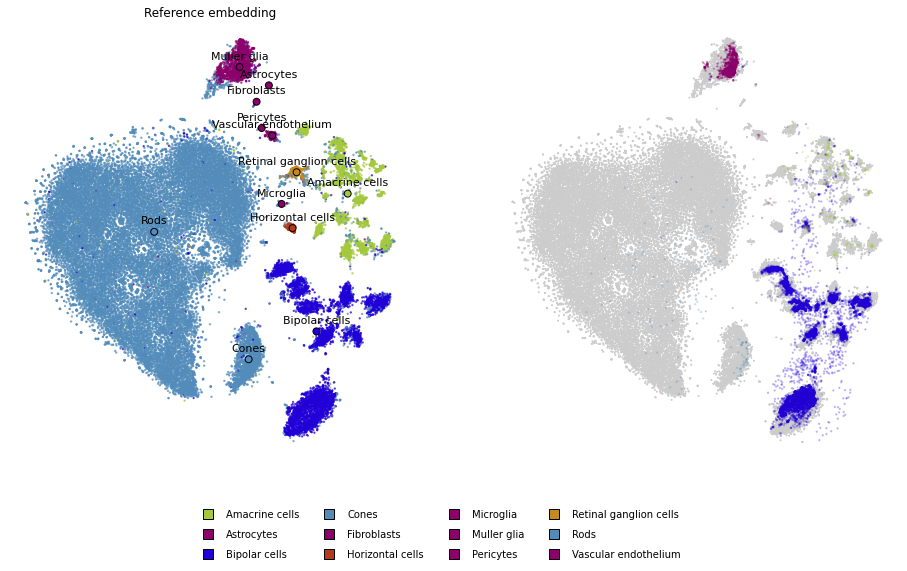

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

utils.plot(
    embedding, adata.obs["labels"], ax=ax[0], title="Reference embedding", s=2, colors=colors,
    draw_centers=True, draw_cluster_labels=True, fontsize=11,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(embedding, np.ones_like(adata.obs_names), ax=ax[1],
           colors=colors_bw, alpha=1, s=1, draw_legend=False)
utils.plot(new_embedding, new.obs["labels"], ax=ax[1],
           draw_legend=False, s=2, alpha=0.2, colors=colors)
#ax[1].set_title("Transformed samples")

for ax_ in ax.ravel(): ax_.axis("equal")

## Final figure

In [66]:
pd.DataFrame(embedding_standard, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("macosko/standard.csv")
pd.DataFrame(embedding_modern, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("macosko/modern.csv")
pd.DataFrame(new_embedding, columns=["tSNE-1", "tSNE-2"], index=new.obs_names).to_csv("macosko/transform_shekhar.csv")

In [67]:
cluster_ids = np.array(adata.obs["cluster_ids"], dtype=float).astype(int)
np.unique(cluster_ids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

In [68]:
cluster_cell_mapping = {
    1: "Horizontal cells",
    2: "Retinal ganglion cells",
    24: "Rods",
    25: "Cones",
    34: "Muller glia",
    35: "Astrocytes",
    36: "Fibroblasts",
    37: "Vascular endothelium",
    38: "Pericytes",
    39: "Microglia",
}
for i in range(3, 24):
    cluster_cell_mapping[i] = "Amacrine cells"
for i in range(26, 34):
    cluster_cell_mapping[i] = "Bipolar cells"

In [69]:
cluster_ids_ = [cluster_cell_mapping[yi] if yi in (1, 2, 24, 25, 34, 35, 36, 37, 38, 39) else yi 
                for yi in cluster_ids]
cluster_ids_ = np.array(cluster_ids_)
np.unique(cluster_ids_)

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '26', '27', '28', '29', '3', '30', '31', '32',
       '33', '4', '5', '6', '7', '8', '9', 'Astrocytes', 'Cones',
       'Fibroblasts', 'Horizontal cells', 'Microglia', 'Muller glia',
       'Pericytes', 'Retinal ganglion cells', 'Rods',
       'Vascular endothelium'], dtype='<U22')

In [70]:
colors_ = {}
for label in np.unique(cluster_ids_):
    try:
        assert int(label) in cluster_cell_mapping
        colors_[label] = colors[cluster_cell_mapping[int(label)]]
    except ValueError:
        colors_[label] = colors[label]
        
np.array(list(colors_.keys()))

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '26', '27', '28', '29', '3', '30', '31', '32',
       '33', '4', '5', '6', '7', '8', '9', 'Astrocytes', 'Cones',
       'Fibroblasts', 'Horizontal cells', 'Microglia', 'Muller glia',
       'Pericytes', 'Retinal ganglion cells', 'Rods',
       'Vascular endothelium'], dtype='<U22')

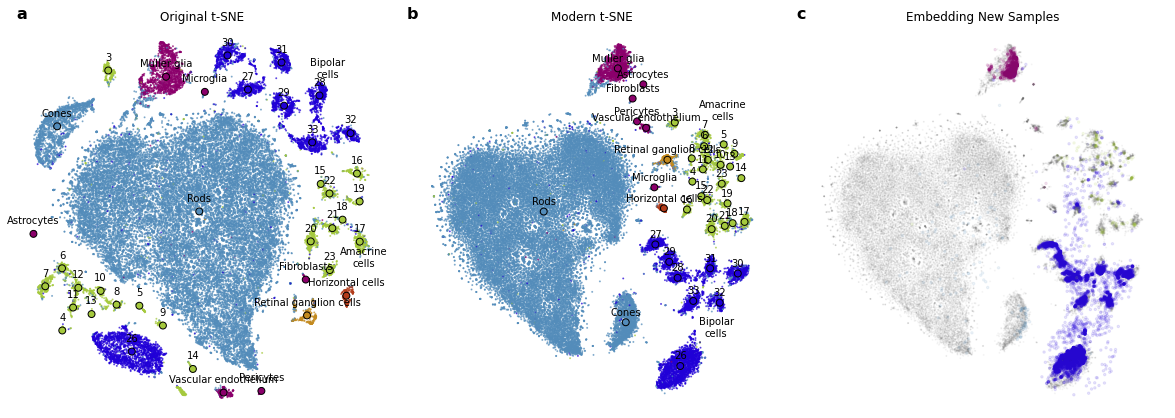

In [71]:
import string

fig, ax = plt.subplots(ncols=3, figsize=(16, 16 / 3))

utils.plot(embedding_standard @ rotate(-120) * [-1, 1], cluster_ids_, colors=colors_, ax=ax[0], fontsize=10,
           draw_centers=True, draw_cluster_labels=True, draw_legend=False, rasterized=True)
ax[0].set_title("Original t-SNE")

utils.plot(embedding_modern, cluster_ids_, colors=colors_, ax=ax[1], fontsize=10,
           draw_centers=True, draw_cluster_labels=True, draw_legend=False, rasterized=True)
ax[1].set_title("Modern t-SNE")

colors_bw = {1: "#666666"}
utils.plot(embedding_modern, np.ones_like(adata.obs["labels"]), colors=colors_bw, ax=ax[2],
           draw_centers=False, draw_legend=False, alpha=0.05, rasterized=True)
utils.plot(new_embedding, new.obs["labels"], colors=colors, ax=ax[2], rasterized=True,
           draw_centers=False, draw_legend=False, alpha=0.1, s=6, lw=0)
ax[2].set_title("Embedding New Samples")

for ax_ in ax.ravel(): ax_.axis("equal")
    
ax[2].set_xlim(ax[1].get_xlim()), ax[2].set_ylim(ax[1].get_ylim())

plt.text(38, -12.5, "Amacrine\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[0].transData)
plt.text(30, 30, "Bipolar\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[0].transData)

plt.text(42, 32, "Amacrine\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[1].transData)
plt.text(40, -38, "Bipolar\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[1].transData)

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase):
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

plt.savefig(path.join("..", "figures", "macosko2015.pdf"), dpi=72, bbox_inches="tight", transparent=True, width=1200/72, height=1200 / 72 / 3)
#plt.savefig(path.join("..", "figures", "macosko2015.tiff"), dpi=150, bbox_inches="tight", transparent=True, width=16, height=16 / 3)